# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Постройте модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59. Проверять *F1*-меру  будем на тестовой выборке.

Дополнительно будем измерять *AUC-ROC*, сравнивая её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)



#### Ход исследования

- исследуем и подготовим предоставленные данные
- разобьем данные на тренировочную и тестовую выборки
- создадим, обучим несколько моделей (pipeline + cv)
- проверим целевой признак на дисбаланс и попробуем исправить его
- выберем наилучшую модель и метод исправления дисбаланса
- проверим результат на тестовой выборке, и сравним с работой dummy модели


#### Итоговый вывод:

В результате данной работы была создана модель предсказывающая уход клиентов банка.
Цель по метрике f1 > 0,59 достигнут. На тестовой выборке результат 0,627
Данная модель обладает достаточно высоким показателем полноты, что важно для целей использования модели.

Возможно для улучшения качества предсказания необходимо ввести дополнительные признаки. Либо оценить данные за несколько месяцев до ухода клиента.

Также необходимо уточнить почему факт ухода не связан с нулевым балансом, что может сильно повлиять на качество модели

На основе результатов исследования рекомендуется использовать модель со следующими параметрами:

RandomForestClassifier(max_depth=8, max_features='log2', min_samples_leaf=7,\n min_samples_split=32, n_estimators=111, random_state=47)

**Описание данных**

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак

* Exited — факт ухода клиента

## Подготовка данных

Установим необходимые библиотеки для работы

In [31]:
import os
import re
from IPython.display import display


from imblearn.under_sampling import RandomUnderSampler # Upscale 
from imblearn.over_sampling import RandomOverSampler # Downscale

import pandas as pd
pd.set_option('max_colwidth', 0)
pd.set_option('display.width', 500)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split


import sweetviz as sv

In [32]:
pth1 = '/content/drive/MyDrive/data/Churn.csv' # Для Colab
pth2 = 'Churn.csv'
if os.path.exists(pth1):
    data = pd.read_csv(pth1)
    print("Датасет успешно загружен с GoogleDrive")
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
    print("Датасет успешно загружен с ЯндексПрактикум")
else:
    print("Проверьте правильность пути к датасету")

Датасет успешно загружен с ЯндексПрактикум


In [33]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [34]:
data.shape

(10000, 14)

В датасете 10000 строк, 13 признаков. 

Приведем название колонок к нижнему регистру

In [35]:
new_columns_name=[]
for column in data.columns:
    new_columns_name.append(re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower())
data.columns = new_columns_name

In [36]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited'], dtype='object')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Есть пропуски в столбце tenure, обработаем их позднее

Построим отчет разбив датасет по целевому признаку

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



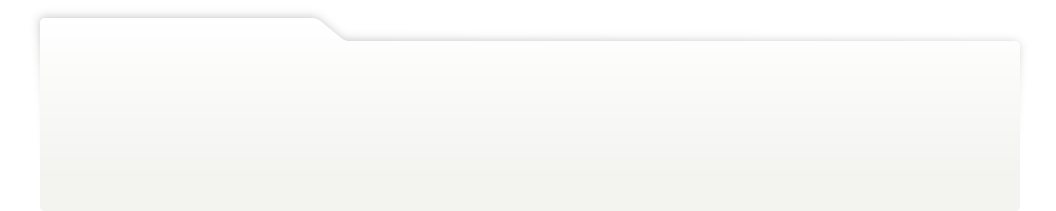
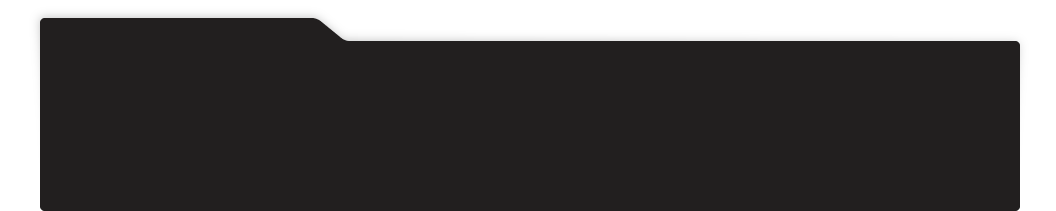
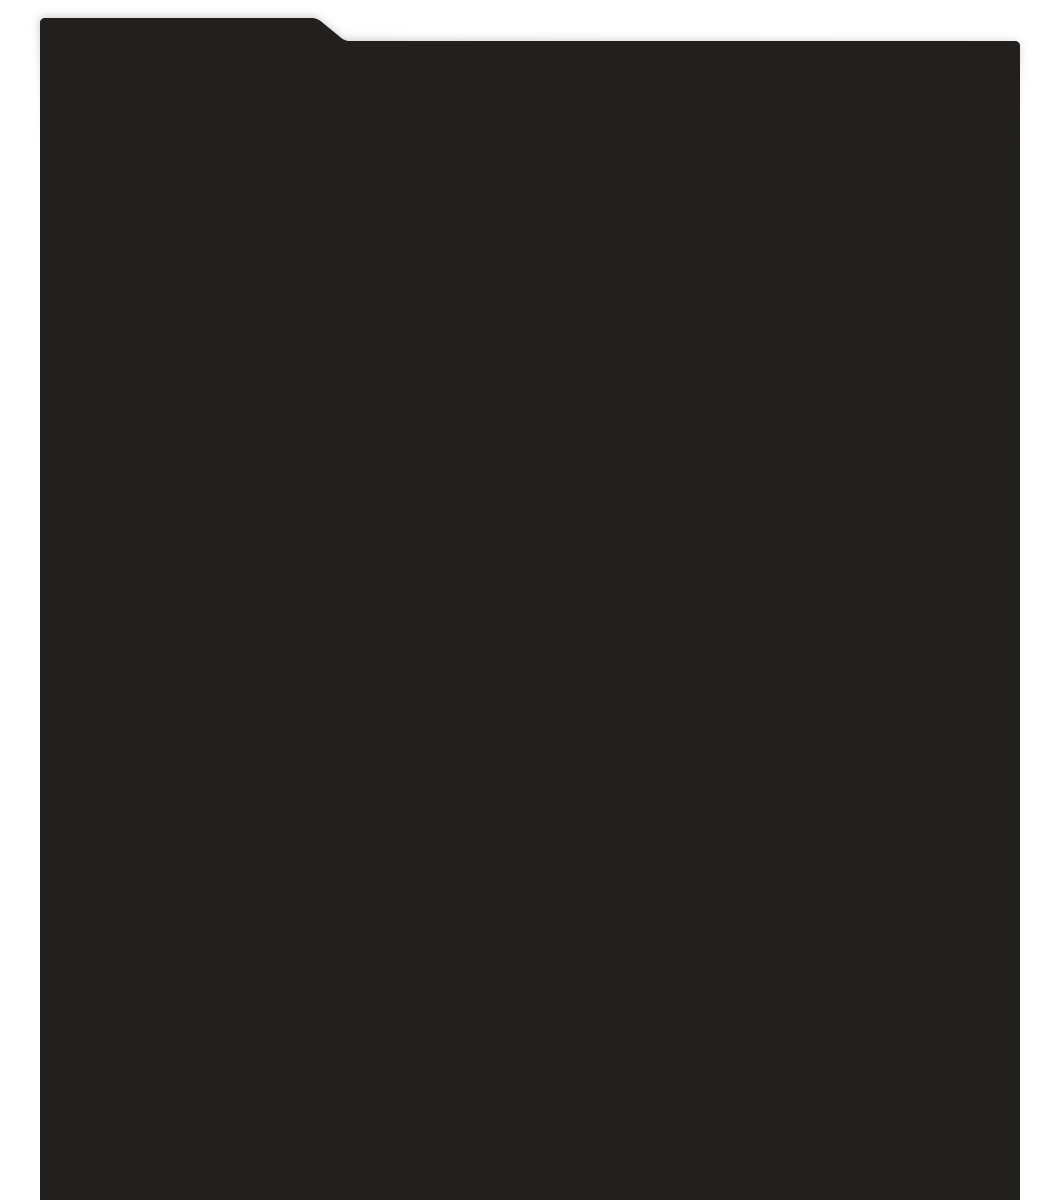
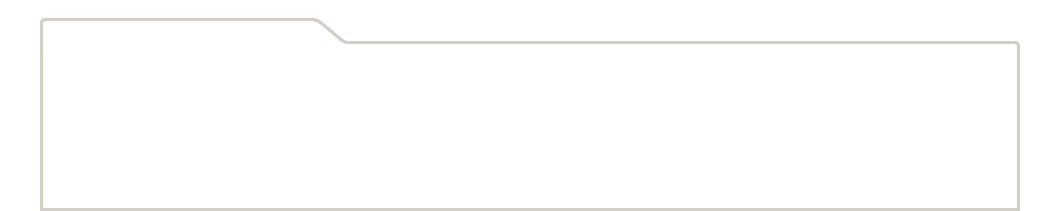
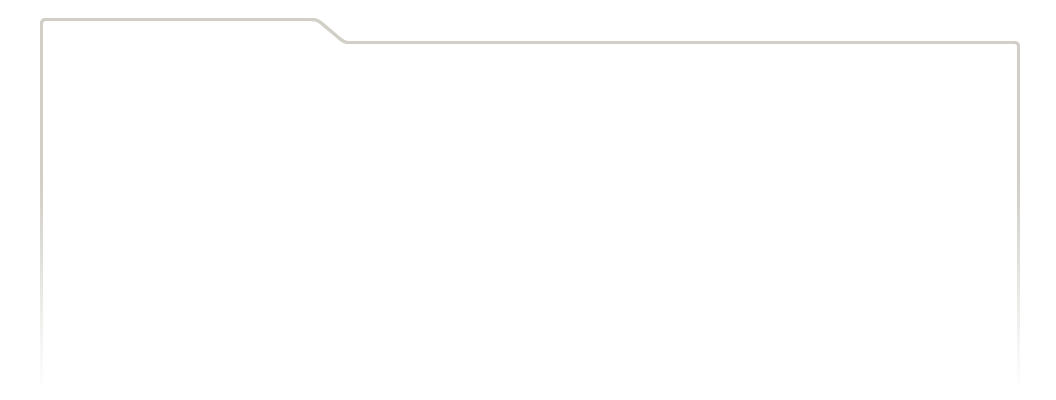
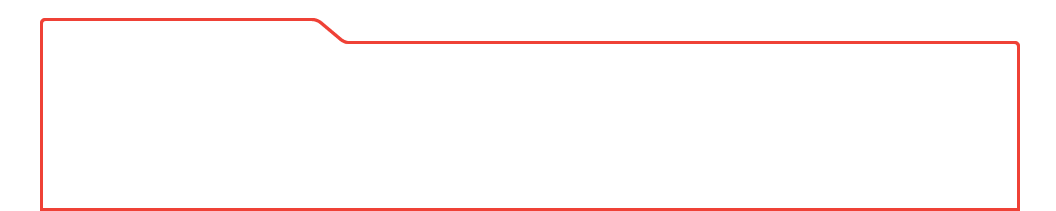
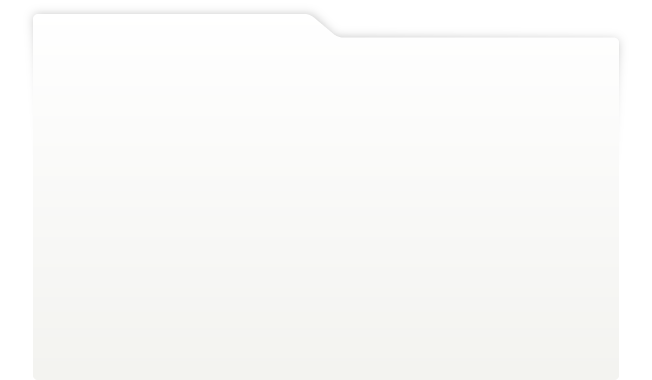
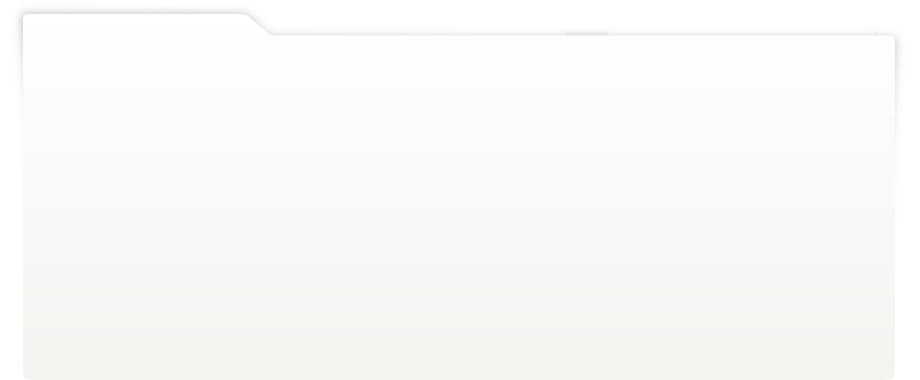
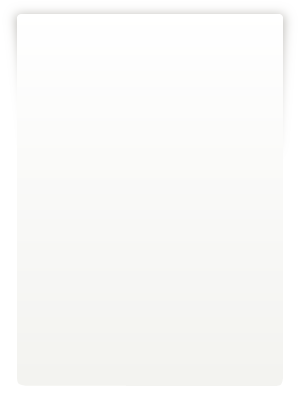
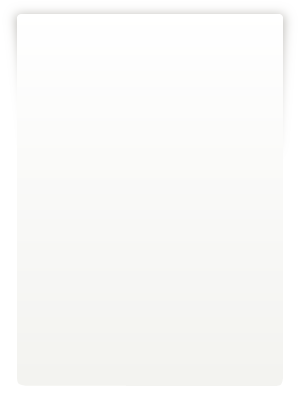
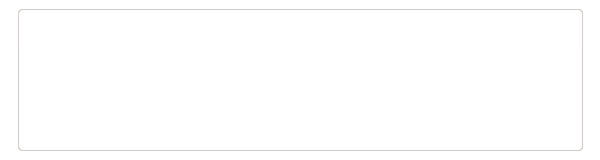
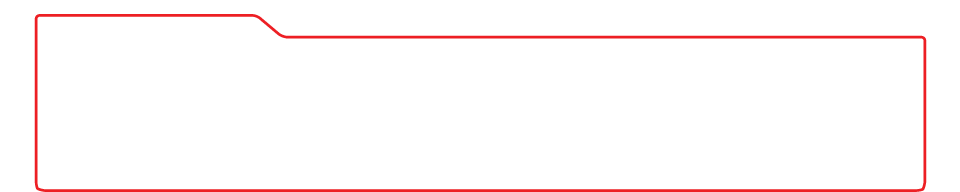
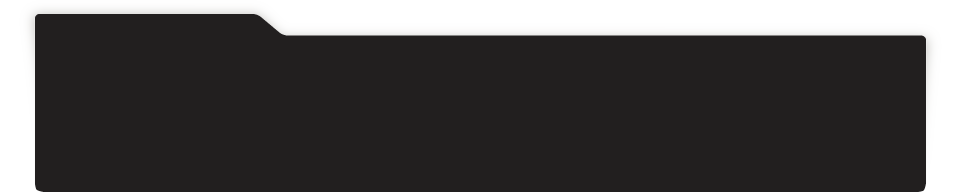
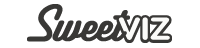
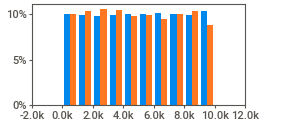
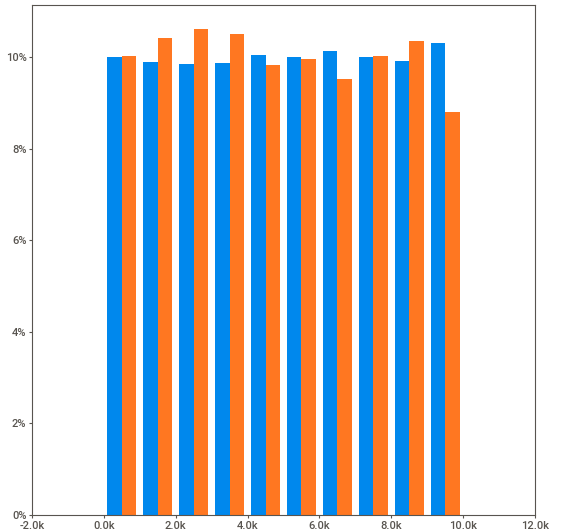
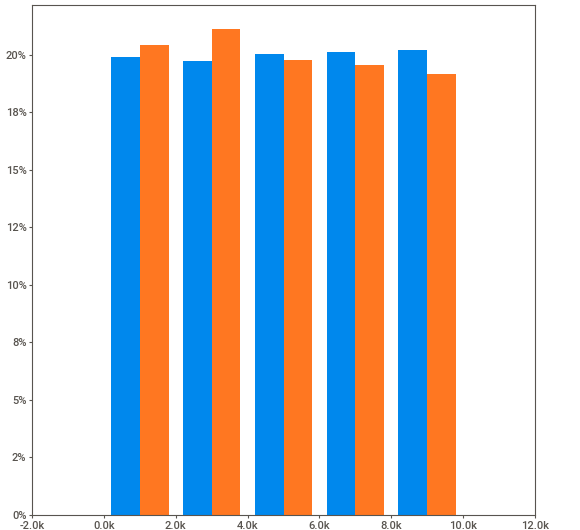
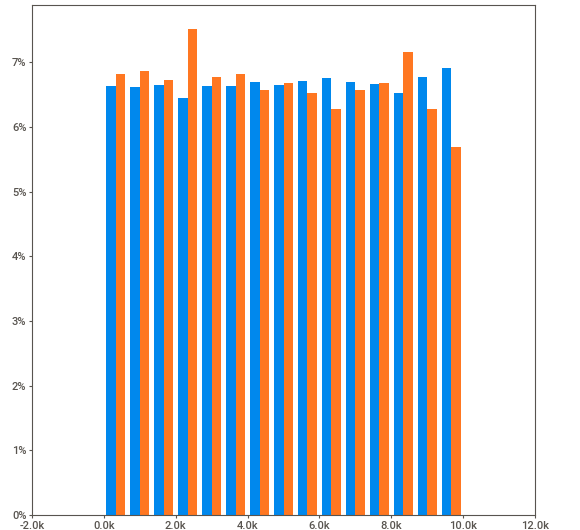
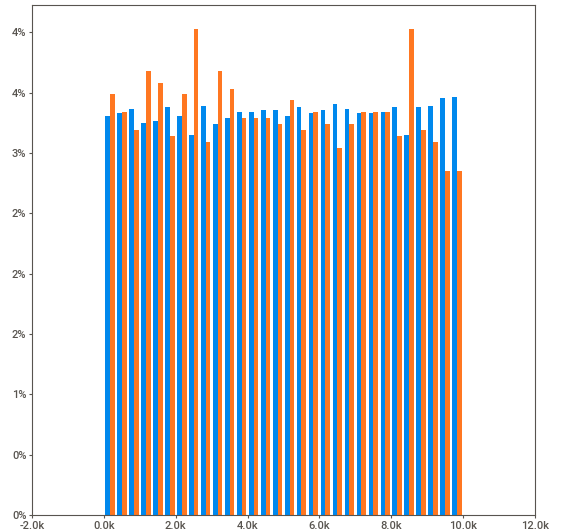
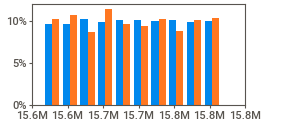
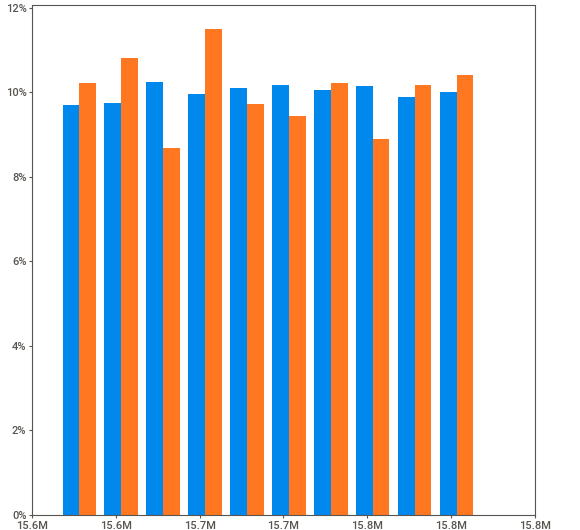
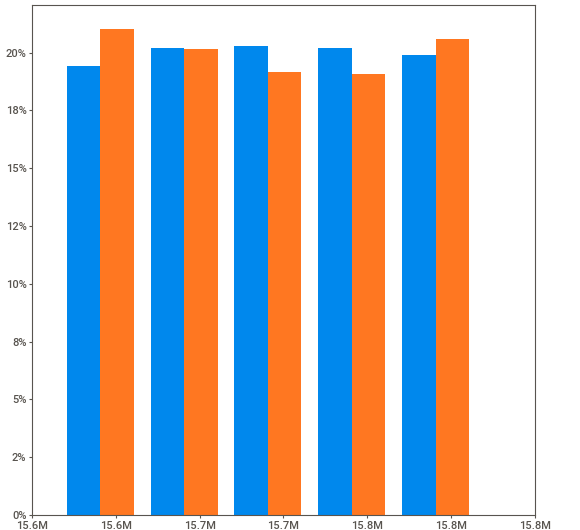
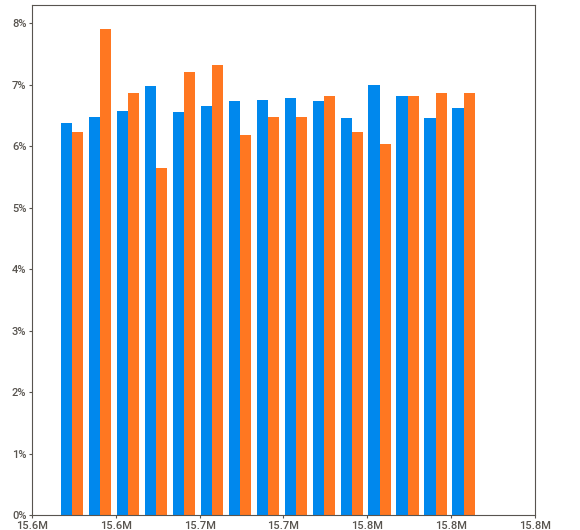
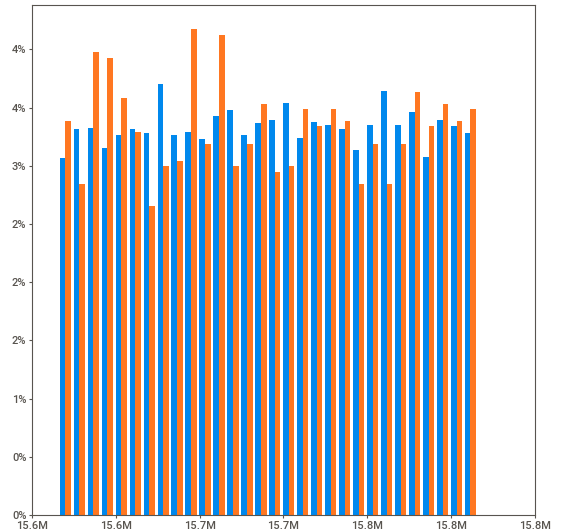
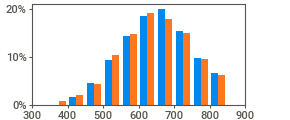
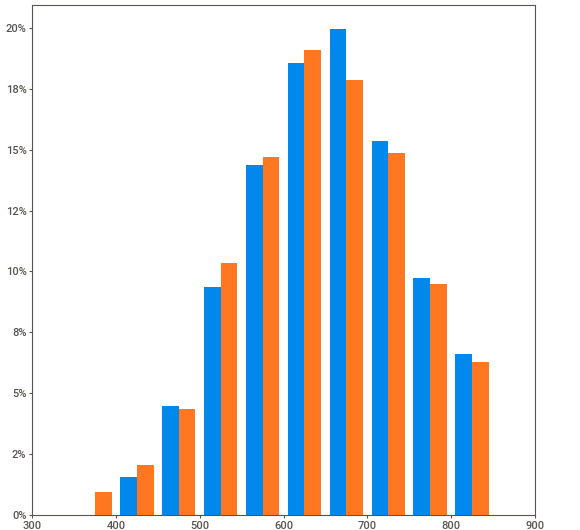
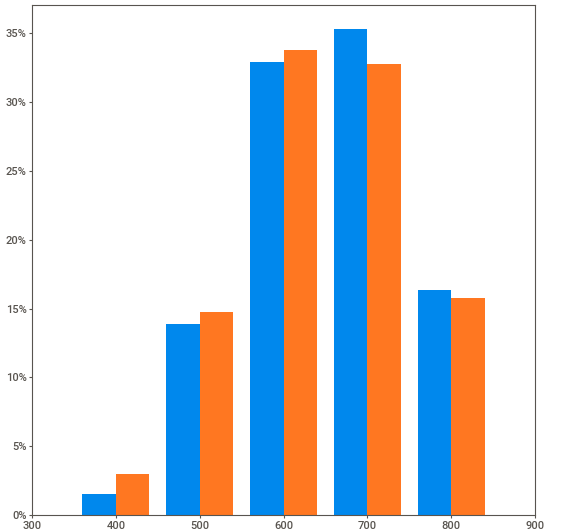
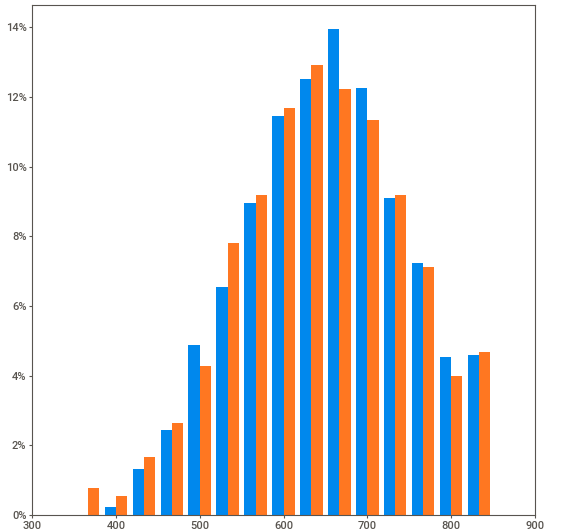
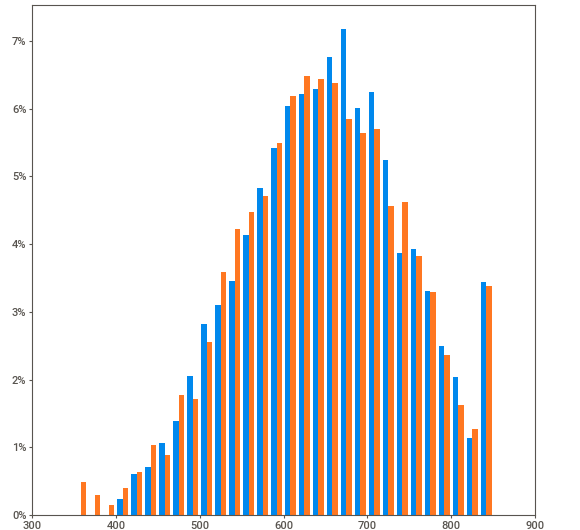
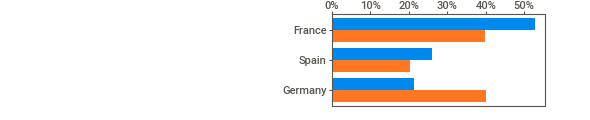
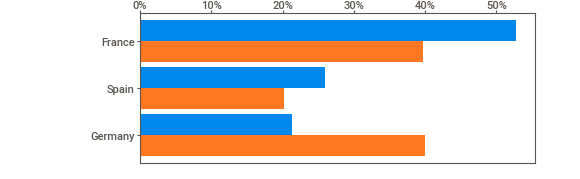
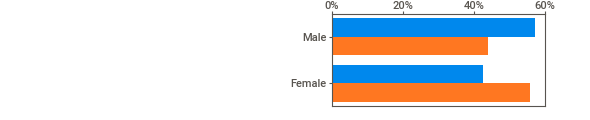
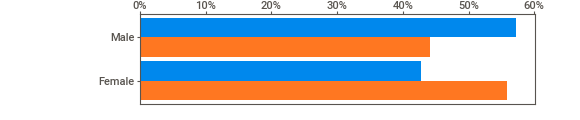
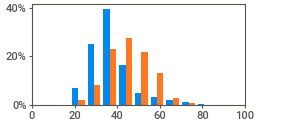
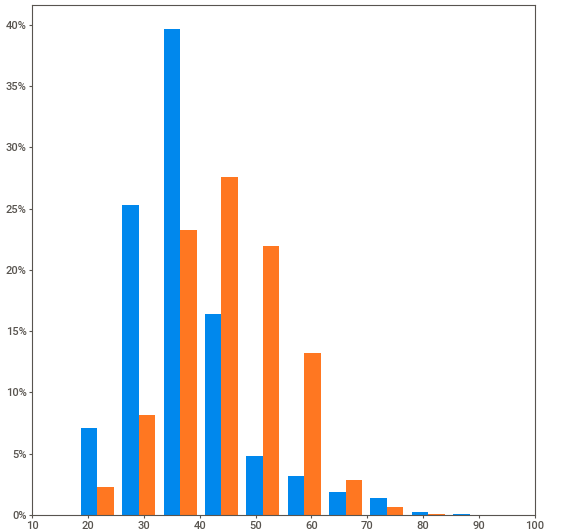
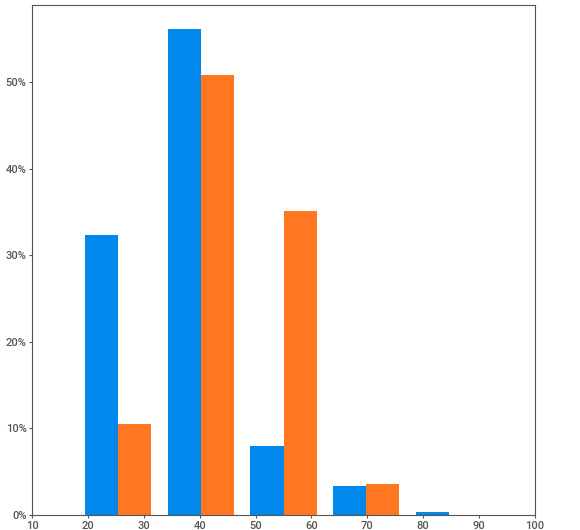
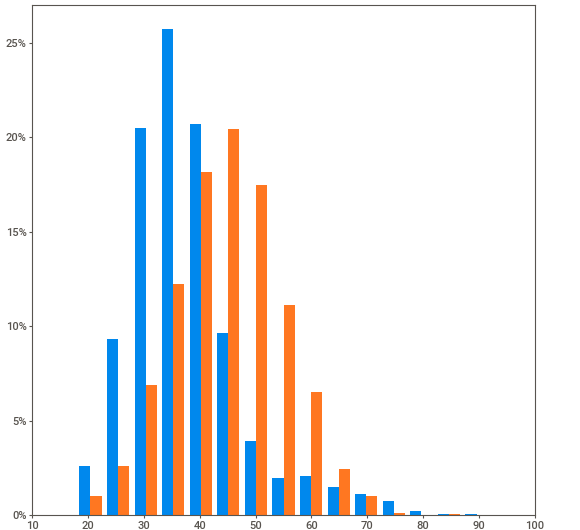
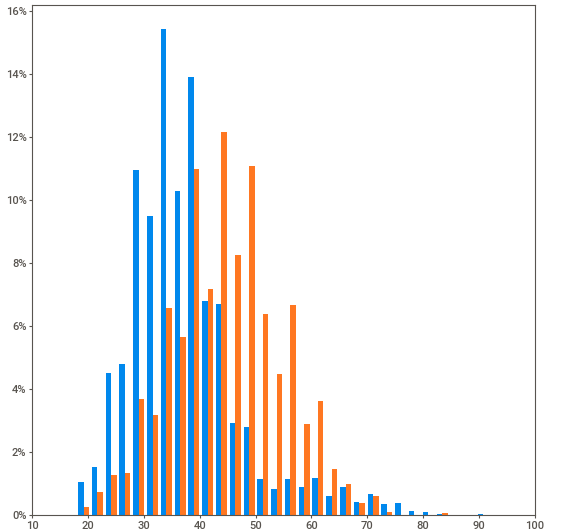
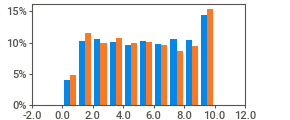
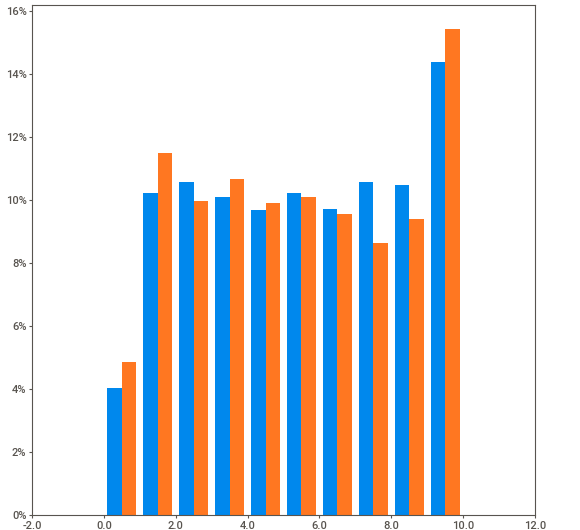
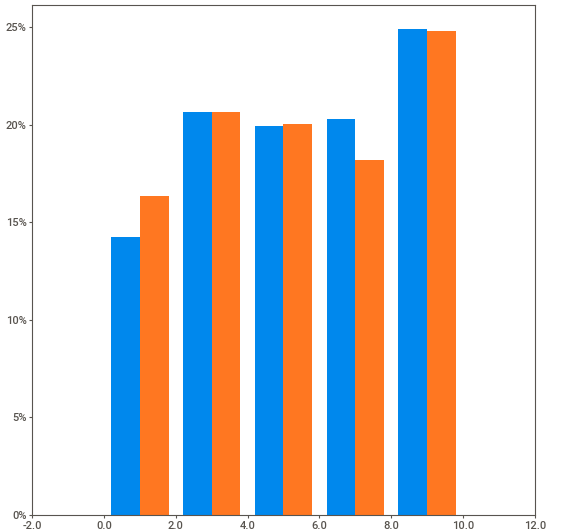
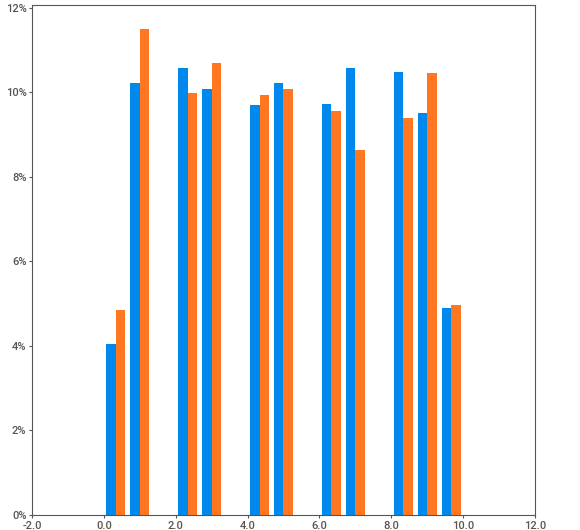
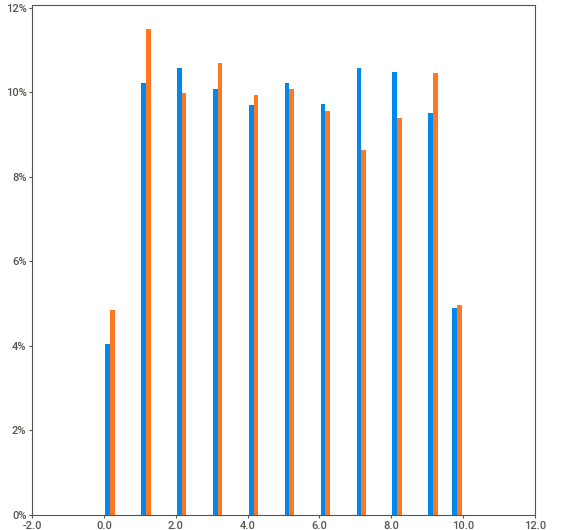
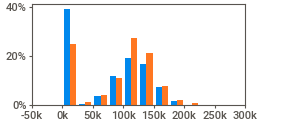
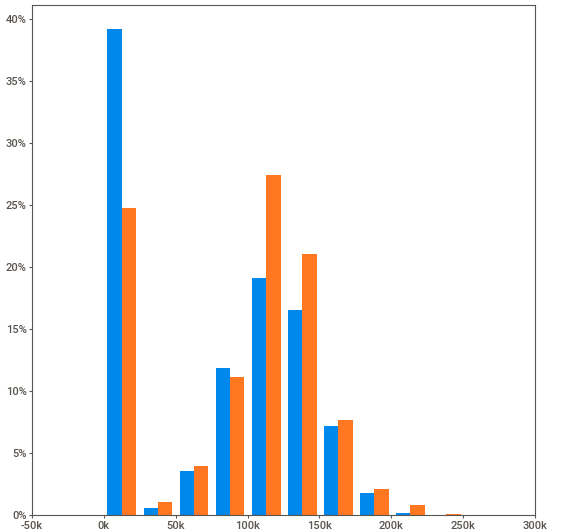
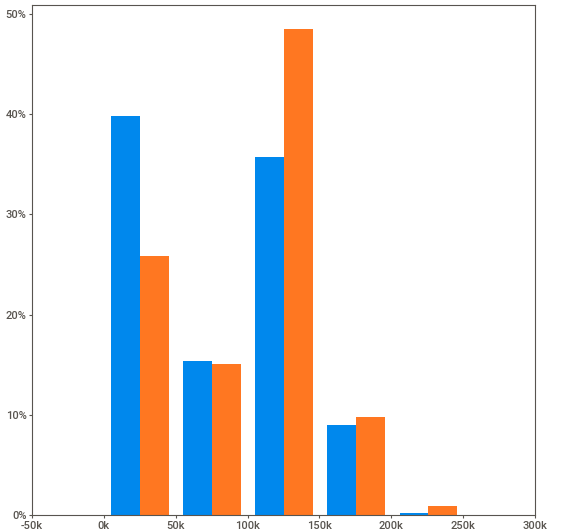
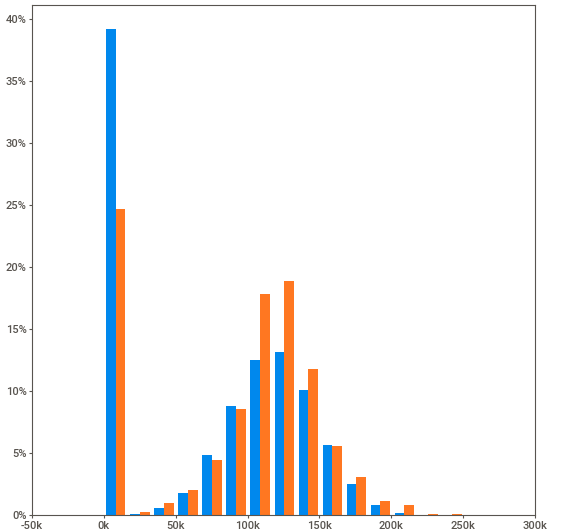
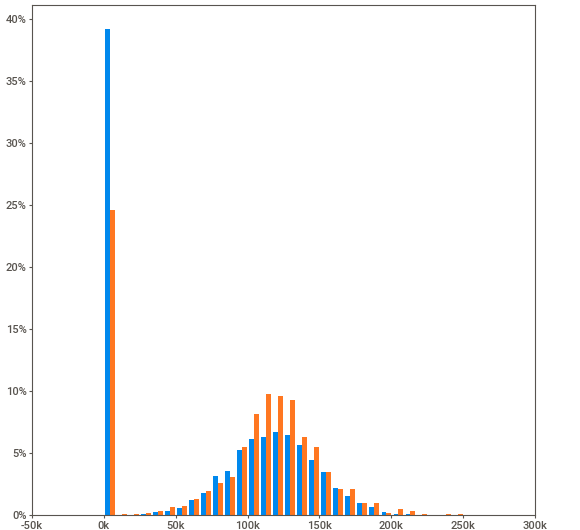
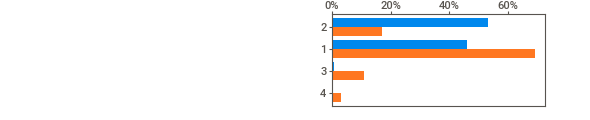
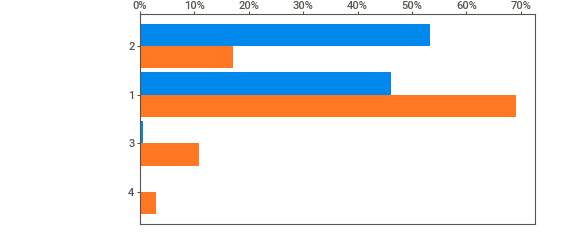
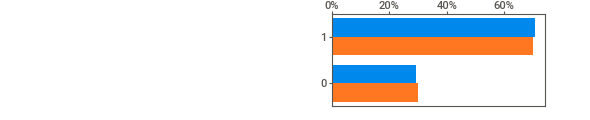
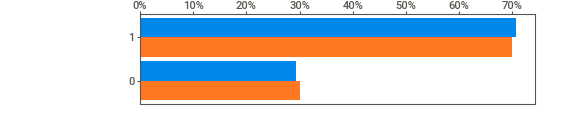
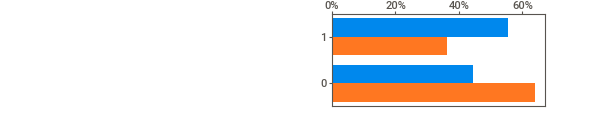
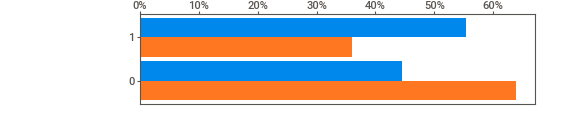
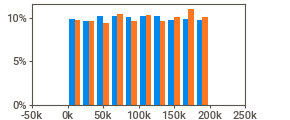
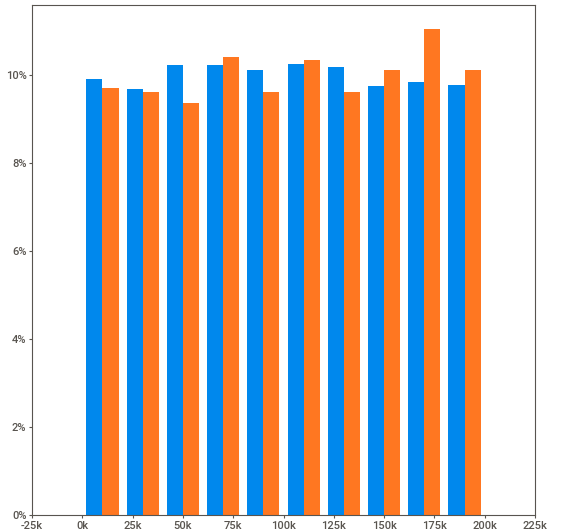
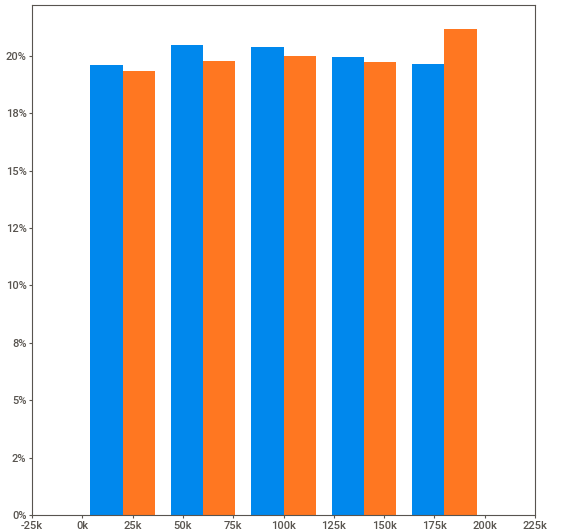
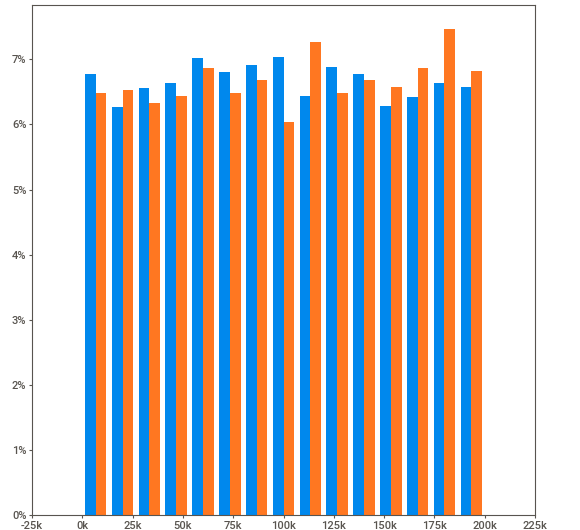
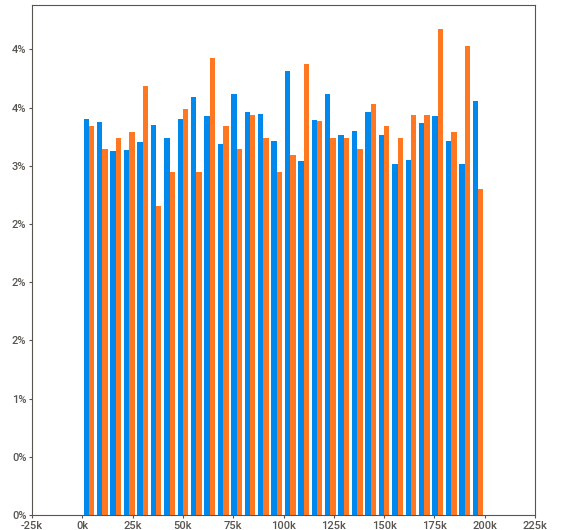
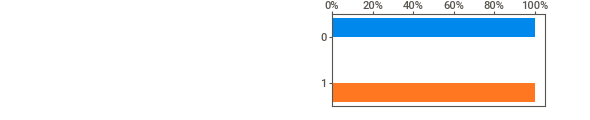
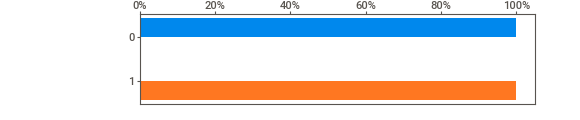
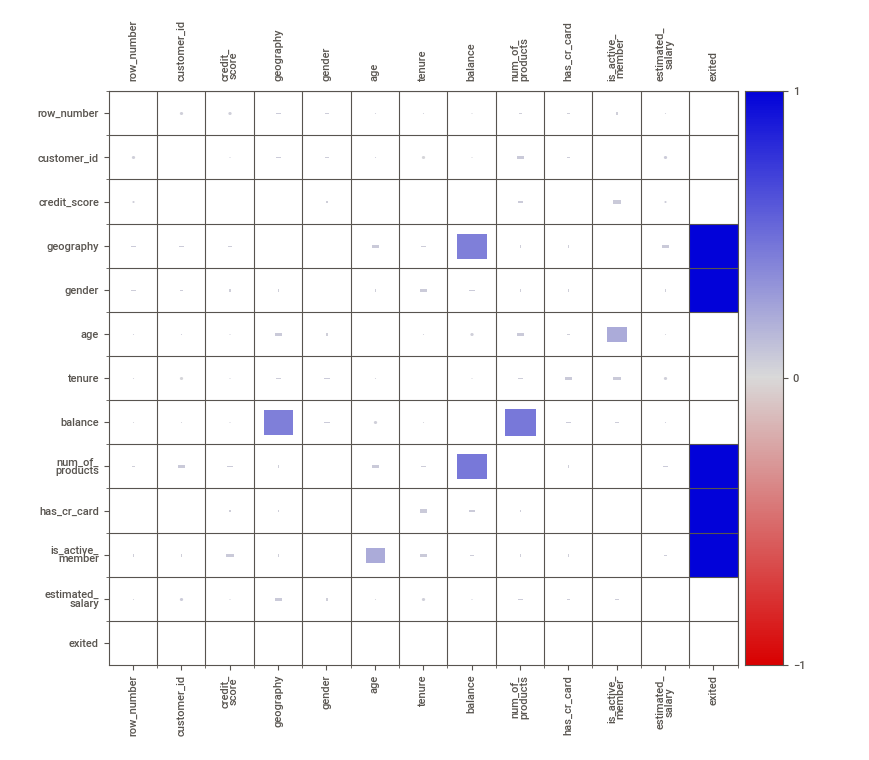
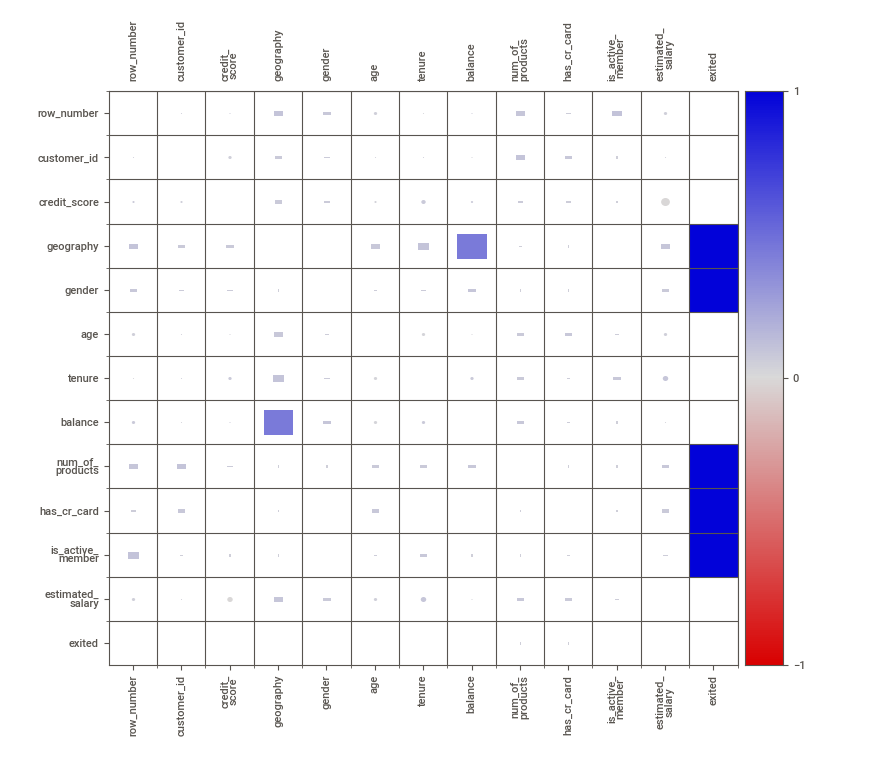

In [38]:
report = sv.compare([data.query('exited == 0'), 'Client'], [data.query('exited == 1'), 'Alien'])
report.show_notebook()

Самая большая доля ушедших клиентов среди пользователей из Германии. Среди ушедших преобладают пользователи старше 45 лет. У 39% пользователей на счету 0. Приэтом медианный баланс на счету у ушедших клиентов != 0 и даже выше чем у действующих клиентов. Необходимо уточнить что почему для ушедших клиентов остается не нулевой баланс.

In [39]:
print('Клиент уходя из банка  в среднем оставляет на счету:', 
      round(data.query('exited == 0')['balance'].mean(), 2))

Клиент уходя из банка  в среднем оставляет на счету: 72745.3


По `credit_score` есть всплеск значений около 850

В датасете представлены жители 3х стран, Болшинство из Франции 53%, остальные из Испании и Германии примерно поровну

В столбце пол два значения. Причем в датасете женщин чуть меньше чем мужчин, но женщин больше ушло из банка

In [40]:
data['customer_id'].nunique()

10000

В столбце 'customer_id' все значения уникальны

In [41]:
data['row_number'].nunique()

10000

'row_number' похоже просто дублирует номера строк

Следовательно полных дубликатов у нас тоже не будет

In [42]:
data[data[['surname', 'geography', 'gender', 'age', 'credit_score']].duplicated()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
7869,7870,15693771,Y?an,651,Spain,Female,45,8.0,95922.90,1,1,0,84782.42,1
9885,9886,15574584,Fang,670,France,Male,33,8.0,126679.69,1,1,1,39451.09,0


Скорее всего просто совпадение, данных чтобы идентифицировать дубликаты не достаточно

Также в таблице встречаются символы ? в фамилиях клиентов, скорее всего из-за преобразования данных и смене кодировок

In [43]:
data.query('surname == "Y?an"')

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
941,942,15676521,Y?an,696,France,Female,31,8.0,0.00,2,0,0,191074.11,0
977,978,15582616,Y?an,520,France,Female,38,4.0,0.00,2,1,0,56388.63,0
2300,2301,15647266,Y?an,651,Spain,Female,45,NaN,135923.16,1,1,0,18732.84,0
5868,5869,15663817,Y?an,713,France,Male,46,5.0,0.00,1,1,1,55701.62,0
6020,6021,15781234,Y?an,609,France,Female,35,NaN,147900.43,1,1,0,140000.29,0
6030,6031,15581388,Y?an,487,Spain,Male,33,8.0,145729.71,1,1,0,41365.85,0
7143,7144,15761158,Y?an,719,France,Female,54,7.0,0.00,2,1,1,125041.52,0
7869,7870,15693771,Y?an,651,Spain,Female,45,8.0,95922.90,1,1,0,84782.42,1
8170,8171,15641366,Y?an,599,Germany,Male,61,1.0,124737.96,1,0,1,90389.61,1
8388,8389,15806570,Y?an,763,France,Female,53,4.0,0.00,1,1,0,77203.72,1


Проверим можно ли восстановить пропуски в 'tenure' по 'customer_id' 

In [44]:
data.pivot_table(values='customer_id', index='tenure', aggfunc=['min', 'max'])

,min,max
,customer_id,customer_id
tenure,,
0.0,15566467,15815534
1.0,15565706,15815660
2.0,15566494,15815626
3.0,15565878,15815428
4.0,15566091,15815125
5.0,15566030,15815236
6.0,15565779,15815552
7.0,15566958,15815560


Похоже что присвоение id идет не по дате 

Заполним пропуск на этапе обучения модели

Проверим нет ли явных зависимостей между признаками в датасете

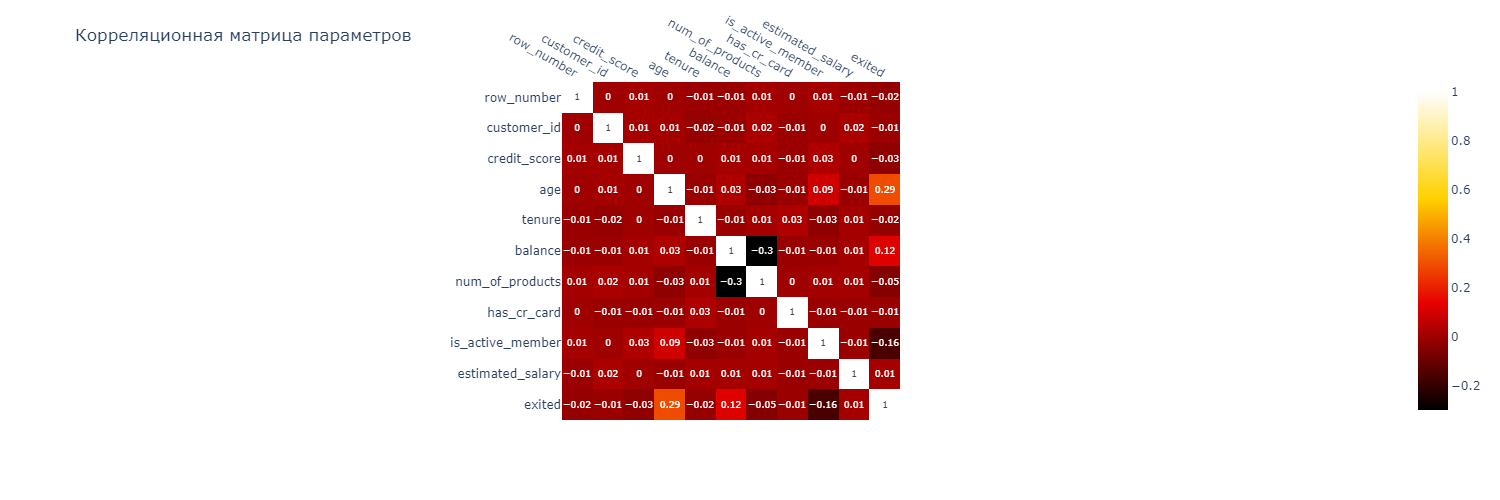

In [45]:
corr_matrix = data.corr().round(2)
    
fig = px.imshow(corr_matrix,
                text_auto=True,
                width=600, 
                height=600,
                color_continuous_scale='Hot')
    
fig.update_xaxes(side="top")
fig.update_layout(title="Корреляционная матрица параметров")
fig.update_layout(width=1500, height=500)
fig.show('png')

Есть очень слабая зависимость между возрастом и фактом ухода, а также количеством продуктов и балансом очень слабая отрицательная корреляция.

Для подготовки модели нам не нужны следующие столбцы, удалим их 'RowNumber', 'customer_id', 'surname'

In [46]:
data = data.reset_index().drop(['row_number', 'customer_id', 'surname'], axis=1)

Преобразуем категориальные переменные

In [47]:
data = pd.get_dummies(data, drop_first=True)

In [48]:
data.head()

,index,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


**Вывод:**

На первом этапе проведено исследование и подготовка данных к обучению модели.
В датасете  10000 строк и 13 признаков.
Обнаружены пропуски в столбце tenure которые будут обработаны на этапе построения модели.


В датасете представлены жители 3х стран, Болшинство из Франции 53%, остальные из Испании и Германии примерно поровну
Также обнаружено что факт ухода клиента из банка не связан со снятием со счет всех денег.

Сильных зависимостей в датасете не обнаружено.
Удалили столбцы 'row_number', 'customer_id', 'surname' как не несущие особо ценной информации.
Преобразовали категориальные переменные.

## Исследование задачи

Проверим как распределен баланс по целевой переменной

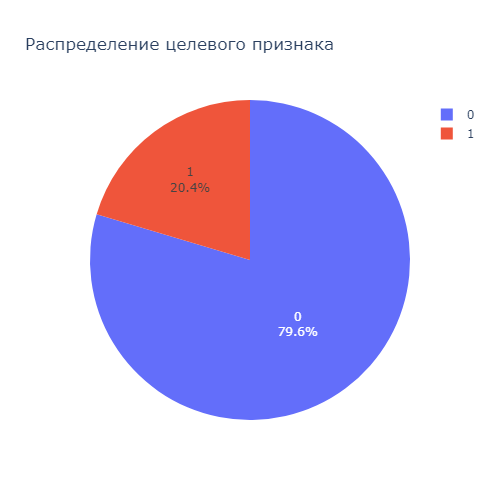

In [49]:
data_exited_pie = data.pivot_table(index='exited', values='tenure', aggfunc='count')

fig = px.pie(data_exited_pie, values='tenure', names=[0, 1], title='Распределение целевого признака')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(width=500, height=500)
fig.show('png')

Учитывая такой результат проверим как модель справиться с таким распределением

Для обучения и проверки качества работы модели разделим датасет на три выборки:

In [50]:
X, y = data.drop(['exited'], axis=1), data['exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=47, 
    stratify=y, 
    shuffle=True)

In [51]:
print('Обучающая выборка')
print('Доля от общего размера:', round(len(y_train)/len(data), 2))
print('Cтрок, столбцов:', X_train.shape)
print('Доля целевого признака:', round(y_train.mean(), 3))
print('-'*30)

print('Тестовая выборка')
print('Доля от общего размера:', round(len(y_test)/len(data), 2))
print('Cтрок, столбцов:', X_test.shape)
print('Доля целевого признака:', round(y_test.mean(), 3))
print('-'*30)

Обучающая выборка
Доля от общего размера: 0.8
Cтрок, столбцов: (8000, 12)
Доля целевого признака: 0.204
------------------------------
Тестовая выборка
Доля от общего размера: 0.2
Cтрок, столбцов: (2000, 12)
Доля целевого признака: 0.203
------------------------------


Используя стратификацию доля целевого признака во всех выборках примерно одинакова для получения качественных результатов

Создадим конвейер(pipeline) в котором данные будут последовательно проходить этапы обработки преобразования и обучения нескольких моделей. Основной метрикой выбрана f1 укажем ее как цель, для модели.

Для заполнения пропущенных значений воспользуемся KNNImputer дающий намного более точный результат вместо заполнения медианой или средним значением.

Для масштабирования признаков воспользуемся RobustScaler, для уменьшения влияния выбросов в столбцах `balance`, `credit_score`

In [52]:
%%time

pipe = Pipeline(
    [
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", RobustScaler()),
        ("regressor", DecisionTreeClassifier()),
    ]
)

param_grid = [
    {
        'regressor': [DecisionTreeClassifier(random_state=47)],
        'regressor__max_depth': range(2,10,1),
        'regressor__min_samples_split': range(2,16,2),
        'regressor__min_samples_leaf': range(2,16,2),
        'regressor__max_features': ['sqrt', 'log2']
    },
    {
        'regressor': [RandomForestClassifier(random_state=47)],
        'regressor__max_depth': range(2,9,1),
        'regressor__n_estimators':range(1,201,10),
        'regressor__min_samples_split':range(2,52,5),
        'regressor__min_samples_leaf':range(2,52,5),
        'regressor__max_features': ['sqrt', 'log2']
    },
    {
        'regressor': [LogisticRegression(random_state=47)],
        'regressor__max_iter': [1000],
        'regressor__class_weight': [None, 'balanced'],
        'regressor__solver' : ['lbfgs', 'liblinear']
    }
]

grid = RandomizedSearchCV(pipe, 
                          param_grid, 
                          n_iter=50,
                          cv=5, 
                          scoring=['accuracy', 'precision', 'f1', 'recall'],
                          refit='f1',
                          n_jobs=-1,
                          random_state=47)

grid.fit(X_train, y_train)

result = pd.DataFrame(grid.cv_results_)
result = result.sort_values('mean_test_f1', ascending=False)
result[
    [
        'param_regressor', 
        'mean_test_f1', 
        'mean_test_recall', 
        'mean_test_accuracy', 
        'mean_test_precision'
    ]
].iloc[:1]

Wall time: 1min 27s


,param_regressor,mean_test_f1,mean_test_recall,mean_test_accuracy,mean_test_precision
10,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",0.537471,0.404294,0.85825,0.803102


Получившиеся значение не достаточно высоко, что не удивительно учитывая дисбаланс 1/4

In [53]:
predicted_valid = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, predicted_valid))

[[6246  124]
 [ 927  703]]


Посмотрим на список моделей которые показали наилучший результат по метрике f1

In [54]:
result = pd.DataFrame(grid.cv_results_)
result.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_estimators,param_regressor__min_samples_split,param_regressor__min_samples_leaf,param_regressor__max_features,param_regressor__max_depth,param_regressor,...,std_test_f1,rank_test_f1,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,1.063144,0.044838,0.145901,0.021565,111,17,12,sqrt,3,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.029291,40,0.104294,0.067485,0.095092,0.095092,0.122699,0.096933,0.017844,39
1,0.972668,0.045957,0.139289,0.015270,61,32,37,sqrt,6,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.024122,18,0.325153,0.285276,0.303681,0.269939,0.322086,0.301227,0.021199,19
2,1.703718,0.031070,0.170398,0.022192,191,17,47,sqrt,5,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.022759,24,0.251534,0.202454,0.230061,0.220859,0.254601,0.231902,0.019459,24
3,0.718990,0.014598,0.123827,0.007167,41,37,17,log2,4,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.022440,31,0.226994,0.196319,0.211656,0.180982,0.220859,0.207362,0.016756,31
4,1.176579,0.095321,0.152327,0.045220,81,32,7,log2,7,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.033709,3,0.426380,0.371166,0.429448,0.349693,0.389571,0.393252,0.031004,3
5,0.951598,0.192918,0.189244,0.055744,31,22,12,sqrt,8,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.027255,4,0.420245,0.377301,0.411043,0.349693,0.404908,0.392638,0.025811,5
6,2.144509,0.096544,0.217800,0.031607,161,22,12,log2,6,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.035474,6,0.411043,0.331288,0.395706,0.325153,0.371166,0.366871,0.034081,7
7,1.029693,0.048998,0.165835,0.035468,111,27,7,log2,2,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.013639,49,0.042945,0.036810,0.030675,0.021472,0.036810,0.033742,0.007259,49
8,0.645103,0.034869,0.130208,0.014408,31,12,12,log2,3,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.026383,36,0.131902,0.095092,0.116564,0.095092,0.131902,0.114110,0.016508,36
9,1.566771,0.130976,0.186491,0.027635,121,17,7,log2,5,"RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,\n n_estimators=71, random_state=47)",...,0.039055,15,0.358896,0.306748,0.306748,0.248466,0.309816,0.306135,0.034996,18


Лидирует RandomForestClassifier с ниже указанными параметрами

In [55]:
print(grid.best_estimator_.named_steps.regressor)

RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=42,
                       n_estimators=71, random_state=47)


Построим кривую ROC-AUC

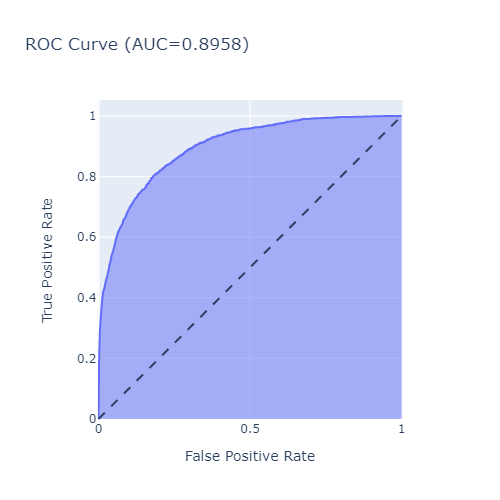

In [56]:
predicted_valid = grid.best_estimator_.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, predicted_valid)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(width=500, height=500)
fig.show('png')

Оценка AUC довольно высокая

**Вывод:**
На данном этапе нами был построен pipline с подбором лучшей модели из трех вариантов, с подбором оптимальных параметров. Лучший результат показывает RandomForestClassifier. Но при проверке метрика f1 не достаточно высока. Учитывая явный дисбаланс по целевому признаку попробуем, добиться лучшего качества отбалансировав тренировочную выборку


## Борьба с дисбалансом

Есть два варианта борьбы с дисбалансом классов первый уменшить количество тех значений которые в целевом признаке принимают 0, второй увеличить количество тех которые принимают 1, примерно выровняв их количество.

Воспользуемся RandomOverSampler и RandomUnderSampler из библиотеки imblearn которые помогут нам для борьбы с дисбалансом классов, протестируем и проверим какой поможет создать модель лучшего качества.

In [58]:
over_sampler = RandomOverSampler(random_state=47)
X_train_up, y_train_up = over_sampler.fit_resample(X_train, y_train)

under_sampler = RandomUnderSampler(random_state=47)
X_train_down, y_train_down = under_sampler.fit_resample(X_train, y_train)

Посмотрим на результат работы с помощью круговых диаграмм

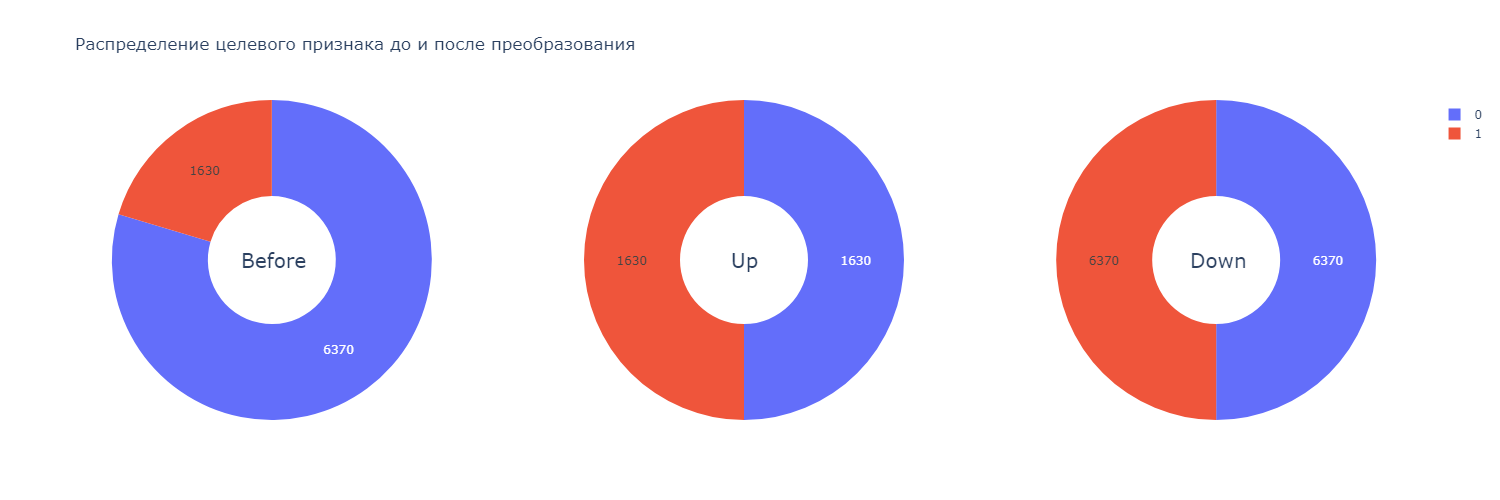

In [64]:
# Датафрейм для pieplot
result = {
        'before': [len(y_train)-sum(y_train), 
                  sum(y_train)], 
        'after_down': [len(y_train_down)-sum(y_train_down), 
                  sum(y_train_down)],
        'after_up': [len(y_train_up)-sum(y_train_up), 
                  sum(y_train_up)]
          }
    
result = pd.DataFrame(data=result)

# Рисуем pie
fig = make_subplots(rows=1, 
                    cols=3, 
                    specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(values=result['before'], name="Before"), 1, 1)
fig.add_trace(go.Pie(values=result['after_down'], name="After UP"), 1, 2)
fig.add_trace(go.Pie(values=result['after_up'], name="After Down"), 1, 3)

fig.update_traces(hole=.4, hoverinfo="label+percent+name", textinfo='value')

fig.update_layout(
    title_text="Распределение целевого признака до и после преобразования")

fig.update_layout(
    annotations=[dict(text='Before', 
                      x=0.12, 
                      y=0.5, 
                      font_size=20, 
                      showarrow=False),
                dict(text='Up', 
                      x=0.50, 
                      y=0.5, 
                      font_size=20, 
                      showarrow=False),
                dict(text='Down', 
                      x=0.88, 
                      y=0.5, 
                      font_size=20, 
                      showarrow=False)])
fig.update_layout(width=1500, height=500)
fig.show('png')

In [65]:
%%time

grid.fit(X_train_down, y_train_down)

result = pd.DataFrame(grid.cv_results_)
result = result.sort_values('mean_test_f1', ascending=False)
result[
    [
        'param_regressor', 
        'mean_test_f1', 
        'mean_test_recall', 
        'mean_test_accuracy', 
        'mean_test_precision'
    ]
].iloc[:1]

Wall time: 32.6 s


,param_regressor,mean_test_f1,mean_test_recall,mean_test_accuracy,mean_test_precision
16,"RandomForestClassifier(max_depth=8, max_features='log2', min_samples_leaf=7,\n min_samples_split=32, n_estimators=111, random_state=47)",0.767364,0.753988,0.771472,0.781447


f1 - после балансирования значительно лучше

In [66]:
print(grid.best_estimator_.named_steps.regressor)

RandomForestClassifier(max_depth=8, max_features='log2', min_samples_leaf=7,
                       min_samples_split=32, n_estimators=111, random_state=47)


Также лучшее значение за RandomForestClassifier

Значения F1 не достаточно высок, похоже что уменьшение для борьбы с дисбалансом сработало в худшую сторону. Количество ложноположительных ошибок значительно увеличилось. Также у нас значительно сократилась обучающая выборка

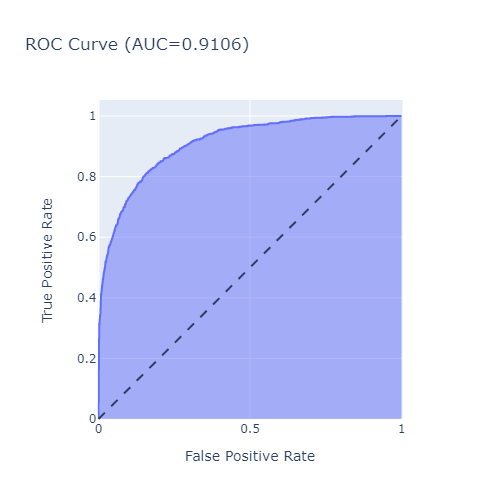

In [67]:
predicted_valid = grid.best_estimator_.predict_proba(X_train_down)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train_down, predicted_valid)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(width=500, height=500)
fig.show('png')

AUC стал лучше, но в целом изменился незначительно

Обучим модель на выборке где мы увеличили количество значений для борьбы с дисбалансом

In [68]:
%%time
grid.fit(X_train_up, y_train_up)

result = pd.DataFrame(grid.cv_results_)
result = result.sort_values('mean_test_f1', ascending=False)
result[
    [
        'param_regressor', 
        'mean_test_f1', 
        'mean_test_recall', 
        'mean_test_accuracy', 
        'mean_test_precision'
    ]
].iloc[:1]

Wall time: 3min 1s


,param_regressor,mean_test_f1,mean_test_recall,mean_test_accuracy,mean_test_precision
16,"RandomForestClassifier(max_depth=8, max_features='log2', min_samples_leaf=7,\n min_samples_split=32, n_estimators=111, random_state=47)",0.808203,0.795761,0.811224,0.821321


Обучение идет значительно дольше, но и результат значительно лучше

Также лучшая модель RandomForestClassifier

Результат лучше за счет уменьшения ложноположительных ошибок и как следствие росту правильных предсказаний TP и TN

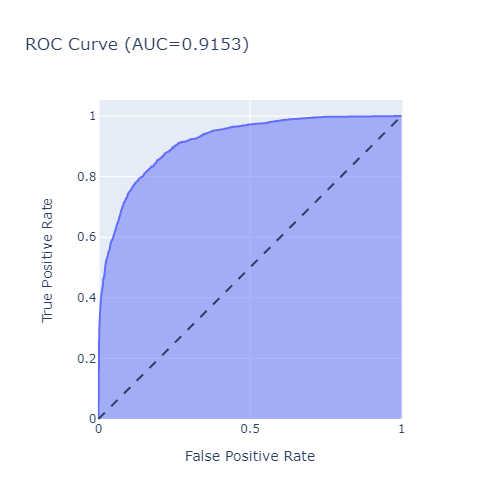

In [69]:
predicted_valid = grid.best_estimator_.predict_proba(X_train_up)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train_up, predicted_valid)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(width=500, height=500)
fig.show('png')

На всем этапе создания и тестировании модели ROC-AUC практически не изменялся

## Тестирование модели

Проверим модель на тестовой выборке

In [70]:
predicted_valid = grid.best_estimator_.predict(X_test)

precision = precision_score(y_test, predicted_valid)
recall = recall_score(y_test, predicted_valid)
f1 = f1_score(y_test, predicted_valid)
accuracy = accuracy_score(y_test, predicted_valid)

print(confusion_matrix(y_test, predicted_valid))
print("Accuracy:", round(accuracy, 3))
print("Полнота:", round(recall, 3))
print("Точность:", round(precision, 3))
print("F1-мера:", round(f1, 3))

[[1339  254]
 [ 105  302]]
Accuracy: 0.82
Полнота: 0.742
Точность: 0.543
F1-мера: 0.627


На тестовой выборке модель показывает не плохой резулльтат. Количество ошибок смещено в сторону ложноположительных, тоесть модель будет показывать что человек может уйти хотя он не собирается. Но учитывая что оставить клиента гораздо ценнее результат хороший

Проверку модели на адекватность выполним с помощью метода DummyClassifier

In [71]:
dum_model = DummyClassifier(strategy="stratified", random_state=47)
dum_model.fit(X_train_up, y_train_up)
dum_pred = dum_model.predict(X_test)

print("F1 DummyClassifier на тестовой выборке:", round(f1_score(y_test, dum_pred), 3))

F1 DummyClassifier на тестовой выборке: 0.273


Модель прошла проверку на адекватность 

**Вывод:**

В результате данной работы была создана модель предсказывающая уход клиентов банка.
Цель по метрике f1 > 0,59 достигнут. На тестовой выборке результат 0,627
Данная модель обладает достаточно высоким показателем полноты, что важно для целей использования модели.

Возможно для улучшения качества предсказания необходимо ввести дополнительные признаки. Либо оценить данные за несколько месяцев до ухода клиента.

Также необходимо уточнить почему факт ухода не связан с нулевым балансом, что может сильно повлиять на качество модели